In [32]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())

def get_pig_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,7]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_seg_FULL_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_4_8_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,6]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_4_6_96", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_olfactory_96():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_96,param_3d.img_size_96,param_3d.img_size_96, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_4_6_96_olfactory", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [45]:
k1=6
k2=6
validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model(k1,k2)
combined_model_128 = combined_model
combined_model_96 = combined_model #0get_pig_model_96()
# combined_model_olfactory_96 = get_pig_model_olfactory_96()

model is loading
models_gmm_seg_FULL_6_6/weights_epoch_980.h5


/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-081_1month/JAW-081_1month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
(192, 192, 192)
prediction shape:  (192, 192, 192, 7) 6


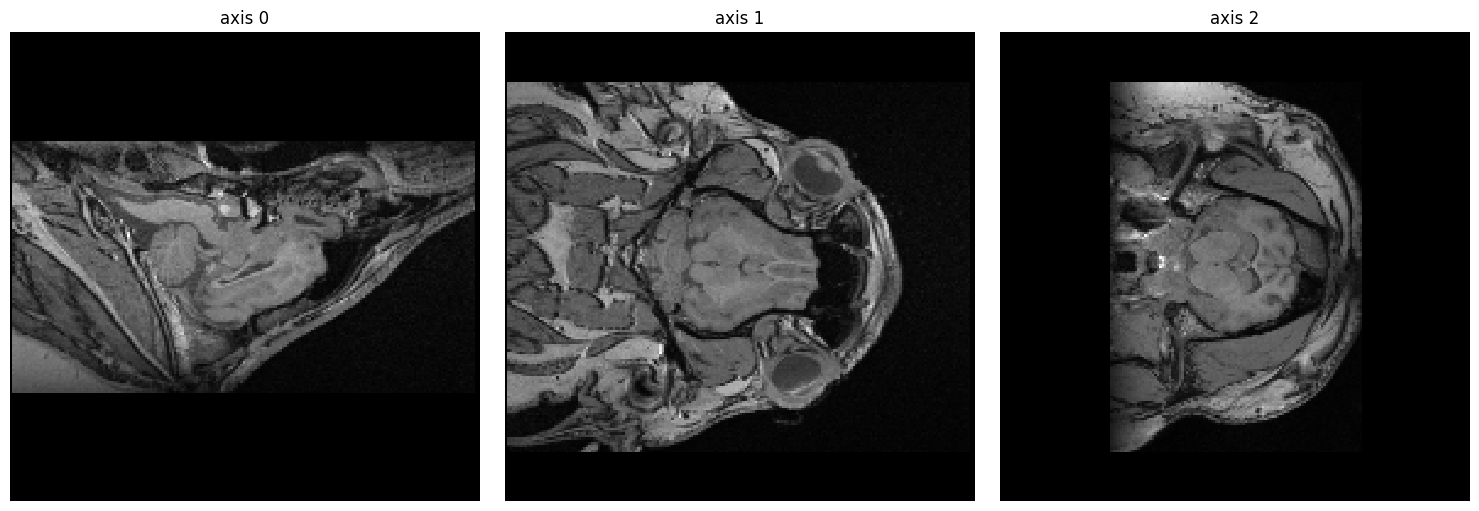

Initial Prediction Result:
first step:  1.275171314689934
first step:  1.275171314689934


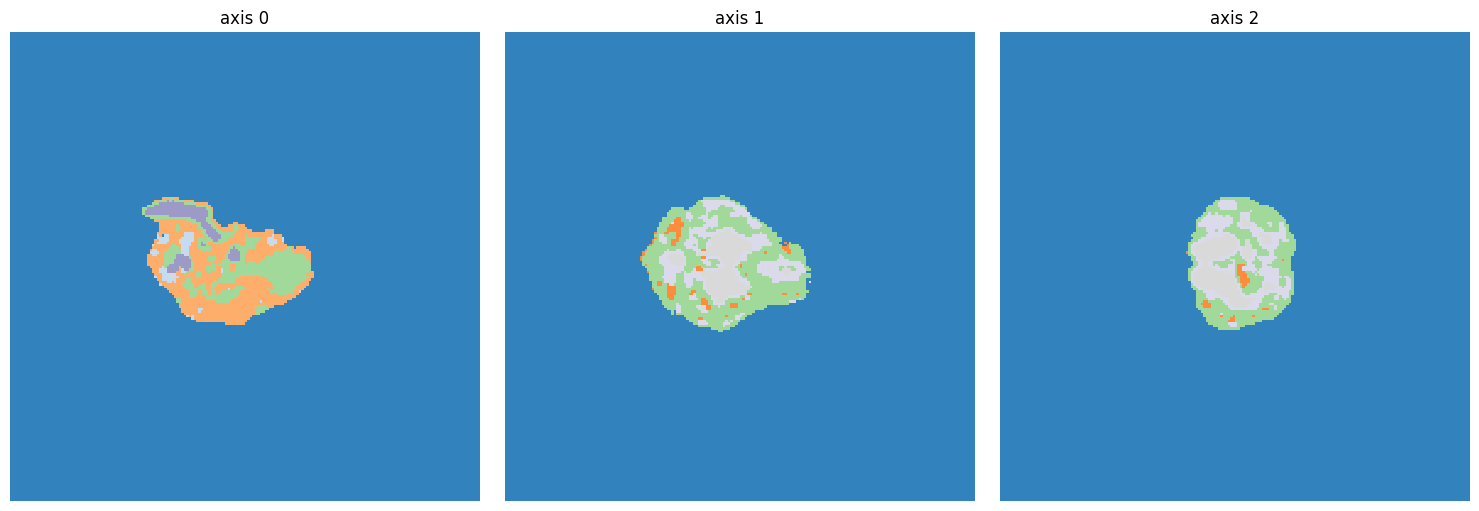

In [46]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import SimpleITK as sitk  # Import SimpleITK for image registration


validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
# validation_folder_path = "results"

subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
# combined_model = get_pig_model(k1,k2)
# combined_model_128 = get_pig_model_128()

import numpy as np

def majority_vote_mask(mask1, mask2, mask3):
    """
    Performs majority voting on three binary masks.
    Voxels with values above 1 in the sum of the masks will be set to 1, others will be set to 0.
    
    Parameters:
    - mask1 (ndarray): First binary mask (same shape as the others).
    - mask2 (ndarray): Second binary mask (same shape as the others).
    - mask3 (ndarray): Third binary mask (same shape as the others).
    
    Returns:
    - final_mask (ndarray): A binary mask where the majority rule is applied.
    """
    # Sum the three masks element-wise
    combined_sum = mask1 + mask2 + mask3
    
    # Apply majority voting: voxels where sum > 1 are set to 1, else 0
    final_mask = (combined_sum > 1).astype(np.int32)
    
    return final_mask

import numpy as np
from scipy.ndimage import label

def majority_vote_olfactory_mask(mask1, mask2, mask3):
    """
    Performs majority voting on three binary masks, but gives special preference to 
    mask3 (capturing olfactory areas) if a connected component is found in mask3 but not in mask1 or mask2.
    
    Parameters:
    - mask1 (ndarray): First binary mask (same shape as the others).
    - mask2 (ndarray): Second binary mask (same shape as the others).
    - mask3 (ndarray): Third binary mask (same shape as the others, capturing olfactory areas).
    
    Returns:
    - final_mask (ndarray): A binary mask where the majority rule is applied, but 
                              connected components in mask3 are prioritized.
    """
    # Sum the three masks element-wise for majority voting
    combined_sum = mask1 + mask2 + mask3
    
    # Apply majority voting: voxels where sum > 1 are set to 1, else 0
    final_mask = (combined_sum > 1).astype(np.int32)

    # Identify connected components in mask3 that are not in mask1 and mask2
    mask3_only = mask3 & (~mask1) & (~mask2)
    
    if np.any(mask3_only):  # If there are any components in mask3 only
        # Label connected components in mask3_only (where mask3 is 1 and mask1, mask2 are 0)
        labeled_components, num_components = label(mask3_only)
        
        # For each connected component in mask3_only, we ensure it's included in the final mask
        for i in range(1, num_components + 1):
            component = (labeled_components == i)
            final_mask[component] = 1  # Ensure all voxels in this component are set to 1 in the final mask
    
    return final_mask

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask

def refine_prediction2(crop_img, mask, model, model_128,model_96, folder, new_image_size=(192, 192, 192), margin=0, cube_size=128):
    """
    Refines the segmentation prediction in two steps:
    1. Makes an initial prediction.
    2. Crops the image based on the prediction and runs the model again.
    
    Parameters:
    - crop_img (ndarray): The input image for prediction.
    - mask (ndarray): The binary mask.
    - model: The trained segmentation model.
    - new_image_size (tuple): The new voxel size for resizing (default is (192, 192, 192)).
    - margin (int): The margin to add around the bounding box (default is 10).
    - cube_size (int): The size of the bounding cube (default is 32).
    
    Returns:
    - final_prediction_resized (ndarray): The final refined prediction, resized to match the original input size.
    """
    folder_path = os.path.join("results", folder)
    os.makedirs(folder_path, exist_ok=True)
    nib.save(nib.Nifti1Image(crop_img, np.eye(4)), os.path.join(folder_path, 'image.nii.gz'))

    # Step 1: Initial Prediction
    # Binarize the mask
    mask.data[mask.data != 0] = 1
    nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4)), os.path.join(folder_path, 'mask.nii.gz'))

    # Compute mask center (using the provided find_bounding_box function)
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    print(crop_img.shape)
    
    # Make an initial prediction
    prediction_one_hot = model.predict(crop_img[None, ...], verbose=0)[0]
    print("prediction shape: ",prediction_one_hot.shape,np.max(np.argmax(prediction_one_hot, axis=-1)))
    initial_prediction = np.argmax(prediction_one_hot, axis=-1)
    ne.plot.volume3D(crop_img, slice_nos=ms)
    print("Initial Prediction Result:")
    print("first step: ",my_hard_dice(mask.data, initial_prediction))

    # labeled, num_components = ndimage.label(initial_prediction > 0)
    # largest_mask = labeled == np.argmax(ndimage.sum(initial_prediction > 0, labeled, range(num_components + 1)))
    # initial_prediction = fill_holes_per_class(largest_mask)
    # initial_prediction = (initial_prediction > 0).astype(np.int32)
    nib.save(nib.Nifti1Image(initial_prediction.astype(np.int32), np.eye(4)), os.path.join(folder_path, 'initial_prediction.nii.gz'))

    print("first step: ",my_hard_dice(mask.data, initial_prediction))

    # # Step 2: Use find_bounding_box function to get the bounding box
    # x1, y1, z1, x2, y2, z2 = find_bounding_box(initial_prediction, cube_size=cube_size)
    # cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=128)


    # pred_192_1 = np.zeros((192,192,192))
    # pred_192_2 = np.zeros((192,192,192))
    
    # ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    # ne.plot.volume3D(cube, slice_nos=ms)

    # # Step 3: Re-run the Model with the cropped image
    # prediction_cropped_one_hot = model_128.predict(cube[None, ...], verbose=0)
    # final_prediction = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    # pred_192_1[x1:x2, y1:y2, z1:z2] = final_prediction
    # pred_192_1[pred_192_1==1]=1
    
    # labeled, num_components = ndimage.label(pred_192_1 > 0)
    # largest_mask = labeled == np.argmax(ndimage.sum(pred_192_1 > 0, labeled, range(num_components + 1)))
    # largest_mask = ndi.binary_fill_holes(largest_mask)
    # pred_192_1 = largest_mask
    # pred_192_1 = (pred_192_1 > 0).astype(np.int32)
    # ne.plot.volume3D(pred_192_1, slice_nos=ms)
    # print("second step: ",my_hard_dice(mask.data, pred_192_1))

    # x1, y1, z1, x2, y2, z2 = find_bounding_box(pred_192_1, cube_size=96)
    # cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=96)

    # prediction_cropped_one_hot = model_96.predict(cube[None, ...], verbose=0)
    # final_prediction = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    # pred_192_2[x1:x2, y1:y2, z1:z2] = final_prediction
    # pred_192_2[pred_192_2==1]=1
    # print("third step: ",my_hard_dice(mask.data, pred_192_2))

    # # print("@@@@@",np.max(pred_192_2))
    # labeled, num_components = ndimage.label(pred_192_2 > 0)
    # largest_mask = labeled == np.argmax(ndimage.sum(pred_192_2 > 0, labeled, range(num_components + 1)))
    # largest_mask = ndi.binary_fill_holes(largest_mask)
    # pred_192_2 = largest_mask
    # pred_192_2 = (pred_192_2 > 0).astype(np.int32)
    # ne.plot.volume3D(pred_192_2, slice_nos=ms)
    # # print("second step: ",my_hard_dice(mask.data, pred_192_2))


    # pred_192 = majority_vote_olfactory_mask(initial_prediction,pred_192_1,pred_192_2)
    # # pred_192 = pred_192_2 #majority_vote_olfactory_mask(initial_prediction,pred_192_1,pred_192_2)

    # # pred_192 = majority_vote_mask(initial_prediction,pred_192_1,pred_192_2)

    # ne.plot.volume3D(pred_192, slice_nos=ms)
    # print("majority voting: ",my_hard_dice(mask.data, pred_192))

    # # Step 4: Resize the final prediction to the original crop_img size
    # # final_prediction_resized = np.resize(final_prediction, (192, 192, 192))
    # nib.save(nib.Nifti1Image(pred_192.astype(np.int32), np.eye(4)), os.path.join(folder_path, 'third_prediction.nii.gz'))
    return initial_prediction

# Store Dice coefficients
dice_scores = []

new_voxsize = [1, 1, 1]

import numpy as np
for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    folder_name = os.path.basename(folder_path)
        
    filename = os.path.join(folder_path, f"{folder_name}_T1.nii.gz")
    mask_filename = os.path.join(folder_path, f"{folder_name}_T1_mask.nii.gz")
    # if "Drew" not in filename:
    #     print("NO MASK FOUND")
    #     continue
            
    if "JAW-106_6month" in filename:
        print("NO MASK FOUND")
        continue

    # if "82" not in filename:
    #     continue

    print(filename)
    
    # Load mask
    if not os.path.isfile(mask_filename):
        mask = sf.Volume(np.ones((192, 192, 192)))
    else:
        mask = sf.load_volume(mask_filename).resize(new_voxsize, method="linear")
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])

    # Skip if no input file
    if not os.path.isfile(filename):
        continue
        
    # Load and process image
    image = sf.load_volume(filename)
    crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])

    # Binarize the mask
    mask.data[mask.data != 0] = 1
    


    # Compute mask center
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    

    prediction = refine_prediction2(crop_img, mask, combined_model,combined_model_128,combined_model_96, folder, new_image_size=(192, 192, 192))
    # prediction = first_prediction(crop_img, mask, combined_model,combined_model_128, folder, new_image_size=(192, 192, 192))

    # print("After Second Prediction:")
    # ne.plot.volume3D(largest_mask, slice_nos=ms)
    ne.plot.volume3D(prediction, slice_nos=ms,cmaps=['tab20c'])
    # Compute Dice coefficient
    mask_flat = mask.data.flatten()
    prediction_flat = prediction.flatten()
    dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))
    if np.sum(mask.data)<1000:
        continue
    dice_scores.append(dice_score)

    # print(f"Dice coefficient for {folder_name}: {dice_score:.4f}")
    break

# Overall Dice coefficient and visualization
overall_dice = np.mean(dice_scores)
# print(f"Overall Dice coefficient: {overall_dice:.4f}")




In [21]:
# np.max(np.argmax(prediction, axis=-1))
np.max(prediction)

5

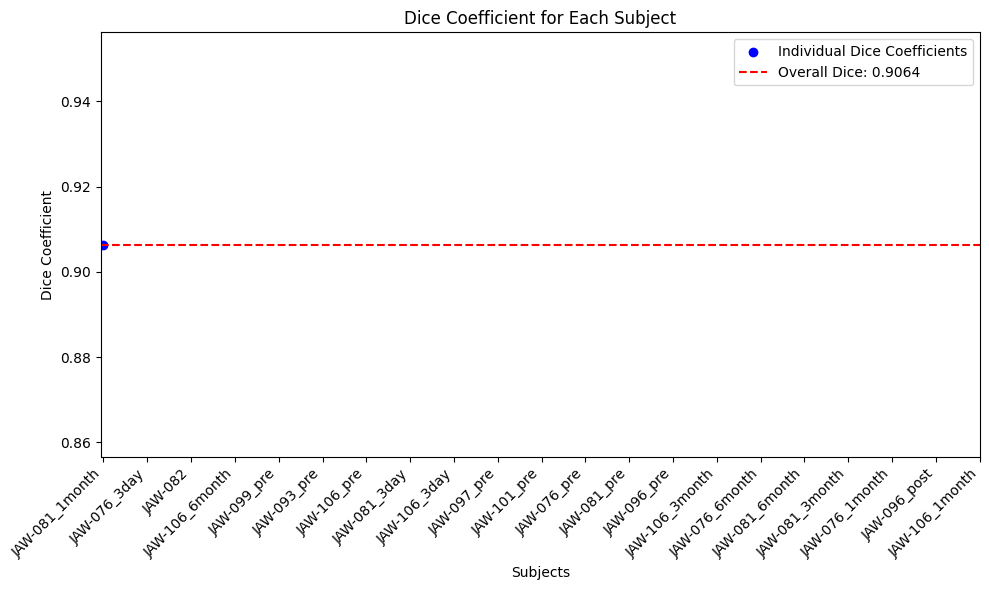

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(dice_scores)), dice_scores, color='blue', label='Individual Dice Coefficients')
plt.axhline(overall_dice, color='red', linestyle='--', label=f'Overall Dice: {overall_dice:.4f}')
plt.xlabel('Subjects')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient for Each Subject')
plt.legend()
plt.xticks(range(len(subfolders)), subfolders, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 73.2 MB/s eta 0:00:00:00:0100:01


[DEBUG] NiftiArrayIO.load(): no header extensions found!


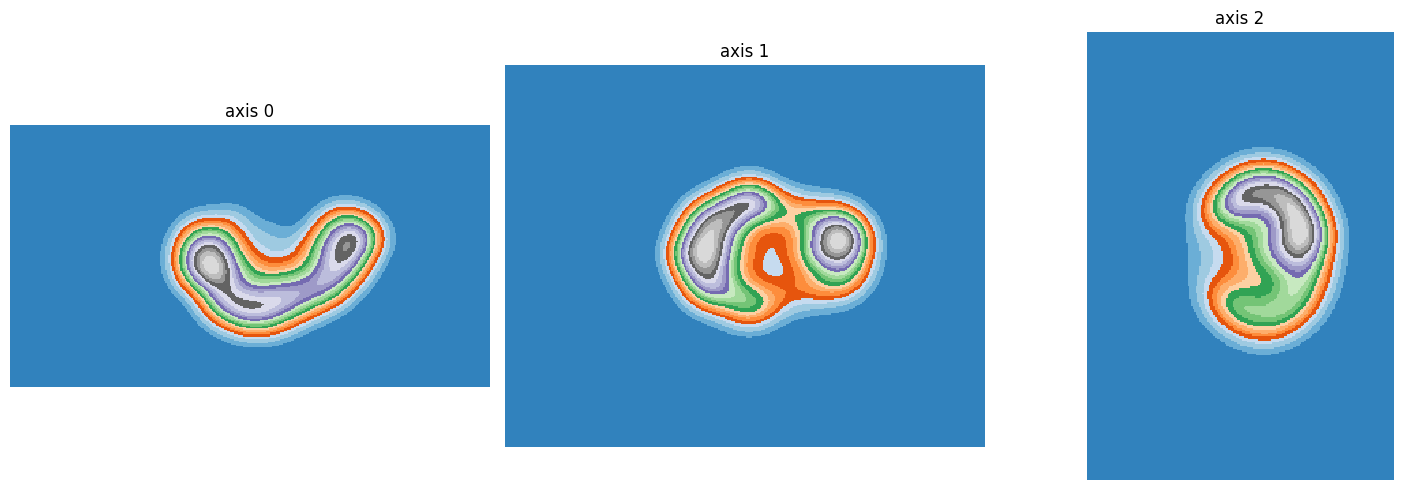

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [28]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube
import SimpleITK as sitk  # Import SimpleITK for image registration
from scipy.ndimage import gaussian_filter

def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=10)
    return np.round(smoothed_labels).astype(int)
    

a=sf.load_volume("/cbica/home/dadashkj/upenn_pigAnatomical/template/french_atlas.nii.gz")
a = make_smooth(a)
ne.plot.volume3D(a,cmaps=['tab20c'])

In [29]:
print(len(np.unique(a.astype(np.int32))))

116


In [26]:
len(np.unique(a))

71834